# IMDb Reviews Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from joblib import load
from sklearn.model_selection import GridSearchCV

In [ ]:
nltk.download('stopwords')
nltk.download("punkt_tab")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Data

In [ ]:
# Load the training dataset
df_train = pd.read_csv("Train.csv")
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
# Load the test dataset
df_test = pd.read_csv("Test.csv")
df_test.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


## Exploratory data analysis (EDA) of Training data

In [ ]:
# Check the shape of the training dataset
print(f'Number of rows and columns: {df_train.shape}')

Number of rows and columns: (40000, 2)


In [ ]:
# Get general information about the training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [ ]:
# How many positive and negative reviews?
label_value_counts = df_train['label'].value_counts()
label_value_counts

,count
label,
0,20019
1,19981


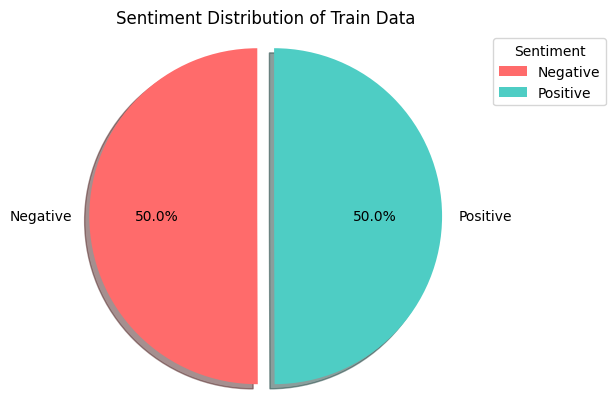

In [ ]:
# Rename labels
label = label_value_counts.index.map({0: 'Negative', 1: 'Positive'})

# plot the distribution of the labels
plt.pie(label_value_counts, labels=label,
        autopct='%1.1f%%', startangle=90, colors = ['#FF6B6B', '#4ECDC4'],
        explode = (0, 0.1), shadow=True)

# Add a legend
plt.legend(
    title="Sentiment",
    loc="upper right",
    bbox_to_anchor=(1.2, 1)  # Move legend outside the pie
)

plt.title('Sentiment Distribution of Train Data')
plt.axis('equal')

plt.savefig("Sentiment_Distribution_Train_Data.png", dpi=300, bbox_inches='tight', transparent=False)


plt.show()

In [ ]:
# How long is the longest review?
length_review = df_train['text'].str.len()
print(f'Longest review: {length_review.max()}')

# How long is the shortest review?
print(f'Shortest review: {length_review.min()}')

Longest review: 13704
Shortest review: 32


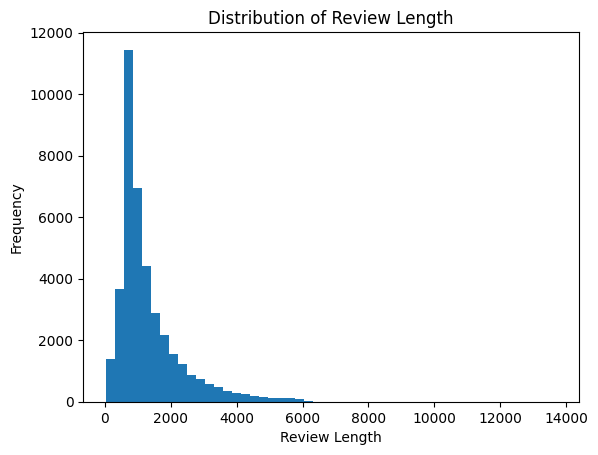

In [ ]:
# Plot the Distribution of Review Length
plt.hist(length_review, bins=50)
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

plt.savefig("Distribution_Review_Length.png", dpi=300, bbox_inches='tight', transparent=False)

plt.show()

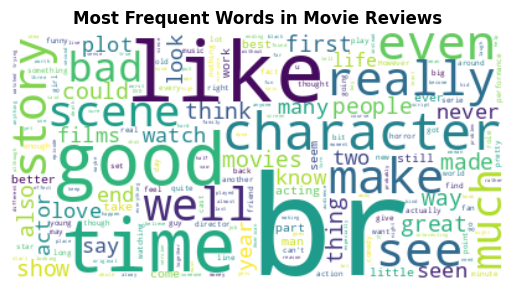

In [ ]:
# Customize stopwords
stop_words = set(stopwords.words("english"))
stop_words.update(["movie", "film", "one", "get", "would"])

# Plot the most frequent words in the reviews
cloud_review = WordCloud(max_words=300,
                         background_color="white",
                         stopwords=stop_words,
                         colormap="viridis",
                         collocations=False,
                         random_state=42
                         ).generate(" ".join(df_train['text']))

plt.imshow(cloud_review, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Movie Reviews", weight='bold')

plt.savefig("movie_reviews_wordcloud.png", dpi=300, bbox_inches='tight', transparent=False)

plt.show()

## Preprocessing

In [ ]:
# Preprocessing text column
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
  '''
  Preprocesses text by:
    1. Tokenizing
    2. Lowercasing
    3. Removing non-alphanumeric words and stopwords
    4. Lemmatizing
  '''
  tokens = word_tokenize(text)
  clean_tokens = [
      lemmatizer.lemmatize(word.lower())
      for word in tokens
      if word.isalnum() and word.lower() not in stop_words]

  return clean_tokens

# Apply the preprocessing function to the text column
df_train['clean_tokens'] = df_train['text'].apply(preprocess_text)
df_train.head()

,text,label,clean_tokens
0,I grew up (b. 1965) watching and loving the Th...,0,"[grew, b, 1965, watching, loving, thunderbird,..."
1,"When I put this movie in my DVD player, and sa...",0,"[put, movie, dvd, player, sat, coke, chip, exp..."
2,Why do people who do not know what a particula...,0,"[people, know, particular, time, past, like, f..."
3,Even though I have great interest in Biblical ...,0,"[even, though, great, interest, biblical, movi..."
4,Im a die hard Dads Army fan and nothing will e...,1,"[im, die, hard, dad, army, fan, nothing, ever,..."


### Handling Negations

In [ ]:
# Define a function to handle negations in the tokens
def handle_negations(tokens):
  '''
  Handles negations in a list of tokens.
  '''
  return [f"not_{tokens[i+1]}" if tokens[i] == 'not' and i+1 < len(tokens)
          else tokens[i]
          for i in range(len(tokens))]

# Apply the negation handling function to the tokens column
df_train['processed_clean_tokens'] = df_train['clean_tokens'].apply(handle_negations)
df_train.head()

,text,label,clean_tokens,processed_clean_tokens
0,I grew up (b. 1965) watching and loving the Th...,0,"[grew, b, 1965, watching, loving, thunderbird,...","[grew, b, 1965, watching, loving, thunderbird,..."
1,"When I put this movie in my DVD player, and sa...",0,"[put, movie, dvd, player, sat, coke, chip, exp...","[put, movie, dvd, player, sat, coke, chip, exp..."
2,Why do people who do not know what a particula...,0,"[people, know, particular, time, past, like, f...","[people, know, particular, time, past, like, f..."
3,Even though I have great interest in Biblical ...,0,"[even, though, great, interest, biblical, movi...","[even, though, great, interest, biblical, movi..."
4,Im a die hard Dads Army fan and nothing will e...,1,"[im, die, hard, dad, army, fan, nothing, ever,...","[im, die, hard, dad, army, fan, nothing, ever,..."


## TF_IDF Vectorization

In [ ]:
# Convert the list of tokens back to a string for TF-IDF vectorization
clean_text = [' '.join(tokens) for tokens in df_train['processed_clean_tokens']]

# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = tfidf.fit_transform(clean_text)
y_train = df_train['label']

# Save the fitted vectorizer for test phase
from joblib import dump
dump(tfidf, 'tfidf_vectorizer.joblib')  

## Preparing Test data

In [ ]:
# Apply the same preprocessing to the test dataset
df_test['clean_tokens'] = df_test['text'].apply(preprocess_text)


df_test['processed_clean_tokens'] = df_test['clean_tokens'].apply(handle_negations)


tfidf = load('tfidf_vectorizer.joblib')

clean_text = [' '.join(tokens) for tokens in df_test['processed_clean_tokens']]
X_test = tfidf.transform(clean_text)
y_test = df_test['label']

## Classification Model

In [ ]:
# Logistic Regression
lgr_model = LogisticRegression()
cross_val_scores = cross_validate(
    lgr_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    return_train_score=True
)

print(f'Train Accuracy: {cross_val_scores["train_score"].mean()}')
print(f'Test Accuracy: {cross_val_scores["test_score"].mean()}')

Train Accuracy: 0.91230625
Test Accuracy: 0.8863


In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
cross_val_scores = cross_validate(
    rf,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    return_train_score=True
)

print(f'Train Accuracy: {cross_val_scores["train_score"].mean()}')
print(f'Test Accuracy: {cross_val_scores["test_score"].mean()}')

Train Accuracy: 1.0
Test Accuracy: 0.8474999999999999


In [ ]:
# Naive Bayes
nb = MultinomialNB()
cross_val_scores = cross_validate(
    nb,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    return_train_score=True
)

print(f'Train Accuracy: {cross_val_scores["train_score"].mean()}')
print(f'Test Accuracy: {cross_val_scores["test_score"].mean()}')

Train Accuracy: 0.8680125000000001
Test Accuracy: 0.8581


In [ ]:
# XGBoost
xgb = XGBClassifier(random_state=42)
cross_val_scores = cross_validate(
    xgb,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    return_train_score=True
)

print(f'Train Accuracy: {cross_val_scores["train_score"].mean()}')
print(f'Test Accuracy: {cross_val_scores["test_score"].mean()}')

Train Accuracy: 0.93585
Test Accuracy: 0.8545


In [ ]:
# LightGBM
lgbm = LGBMClassifier(random_state=42)
cross_val_scores = cross_validate(
    lgbm,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    return_train_score=True
)

print(f'Train Accuracy: {cross_val_scores["train_score"].mean()}')
print(f'Test Accuracy: {cross_val_scores["test_score"].mean()}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15985, number of negative: 16015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.526693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540441
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499531 -> initscore=-0.001875
[LightGBM] [Info] Start training from score -0.001875


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15985, number of negative: 16015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.963354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 539771
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499531 -> initscore=-0.001875
[LightGBM] [Info] Start training from score -0.001875


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15985, number of negative: 16015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.905245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 541775
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499531 -> initscore=-0.001875
[LightGBM] [Info] Start training from score -0.001875


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15985, number of negative: 16015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.933918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540104
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499531 -> initscore=-0.001875
[LightGBM] [Info] Start training from score -0.001875


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15984, number of negative: 16016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.966704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540062
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499500 -> initscore=-0.002000
[LightGBM] [Info] Start training from score -0.002000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Train Accuracy: 0.9051937500000001
Test Accuracy: 0.861425


## Logistic Regression Tuning

In [ ]:
# Parameter grid for LR
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'solver': ['saga'],  # Supports all penalties
    'l1_ratio': [0.3, 0.5, 0.7]  # For elasticnet
}

# Perform Grid Search for Logistic Regression
lr = LogisticRegression(max_iter=5000, random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best LR: {grid_search.best_score_:.3f}")
print(f"Best params: {grid_search.best_params_}")

Best LR: 0.886
Best params: {'C': 1, 'l1_ratio': 0.3, 'penalty': 'elasticnet', 'solver': 'saga'}


## Evaluate on TEST SET

In [ ]:
# Best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Performance metrics
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Set Evaluation:
Accuracy: 0.889
Precision: 0.883
Recall: 0.897
F1-Score: 0.890

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2495
           1       0.88      0.90      0.89      2505

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000


Confusion Matrix:
[[2197  298]
 [ 257 2248]]
